In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import PyCO2SYS as pyco2
from scipy.interpolate import PchipInterpolator

df = pd.read_csv("../compilation/data/in_situ_rates_compiled_allvar_uncertainty.csv")


import pylab
NUM_COLORS = len(df["Source_abbrev"].unique())
cm = pylab.get_cmap('turbo')
colors = []
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)
    colors.append(color)

In [3]:
# fill all nan errors with 0
df['Rate_error_sa'] = df['Rate_error_sa'].fillna(0)
df['Rate_error_mass'] = df['Rate_error_mass'].fillna(0)

### use CDisK4 Omega and uncertainty

In [4]:
# add uncertainty
df['u_TA_CDisk4'] = 4 # n19
df['u_pH_CDisk4'] = 0.001 # n19
df['u_PO4_CDisk4'] = 0.03 # n19, their uncertainty but 'my' nutrient data
df['u_SiOH4_CDisk4'] = 1.5 # n19, their uncertainty but 'my' nutrient data
df['u_Temp_CDisk4'] = df["Temp_CDisk4"]*0.02 # based on Table 3, GLODAPv2.2022 data
df['u_Sal_CDisk4'] = 0.005 # based on Table 3, GLODAPv2.2022 data


# re-calculate Omega_calc for CDisk so I have the uncertainty
cdisk = pyco2.sys(par1=df["TA_CDisk4"], 
                    par2=df["pH_CDisk4_T25"], 
                    par1_type = 1, par2_type=3, 
                    salinity=df["Salinity_CDisk4"], 
                    temperature_out=df["Temp_CDisk4"], 
                    pressure_out=df["Pressure"],
                    total_silicate=df["SiOH4_cb"], 
                    total_phosphate=df["PO4_cb"],
                  uncertainty_into=["saturation_calcite_out", "saturation_aragonite_out"],
                  uncertainty_from={
                      "par1": df['u_TA_CDisk4'],
                      "par2": df['u_pH_CDisk4'],
                      "salinity": df['u_Sal_CDisk4'] ,                   
                      "temperature": df['u_Temp_CDisk4'],
                      "total_silicate": df['u_SiOH4_CDisk4'],
                      "total_phosphate": df['u_PO4_CDisk4']})


df["pH_insitu_CDisk4"] = cdisk['pH_out']

# calculated myself
df["Oca_CDisk4_calc13_calc"] = cdisk['saturation_calcite_out']
df["Oar_CDisk4_calc13_calc"] = cdisk['saturation_aragonite_out']
df["u_Oca_CDisk4_calc13_calc"] = cdisk['u_saturation_calcite_out']
df["u_Oar_CDisk4_calc13_calc"] = cdisk['u_saturation_aragonite_out']


df["Omega_CDisk4_calc13_calc"] = np.where(df["Material"].eq("Aragonite"), 
                                             df["Oar_CDisk4_calc13_calc"], df["Oca_CDisk4_calc13_calc"])
df["u_Omega_CDisk4_calc13_calc"] = np.where(df["Material"].eq("Aragonite"), 
                                             df["u_Oar_CDisk4_calc13_calc"], df["u_Oca_CDisk4_calc13_calc"])


# make new column for Omega I use (estimated for all except the CDisK-IV ones)
df["Omega_use"] = np.where(df["Omega_CDisk4_calc13"].isna(), 
                                             df["Omega_calc23"], df["Omega_CDisk4_calc13"])
df["u_Omega_use"] = np.where(df["Omega_CDisk4_calc13"].isna(), 
                                             df["u_Omega_calc23"], df["u_Omega_CDisk4_calc13_calc"])

# Histograms

## Figure 4

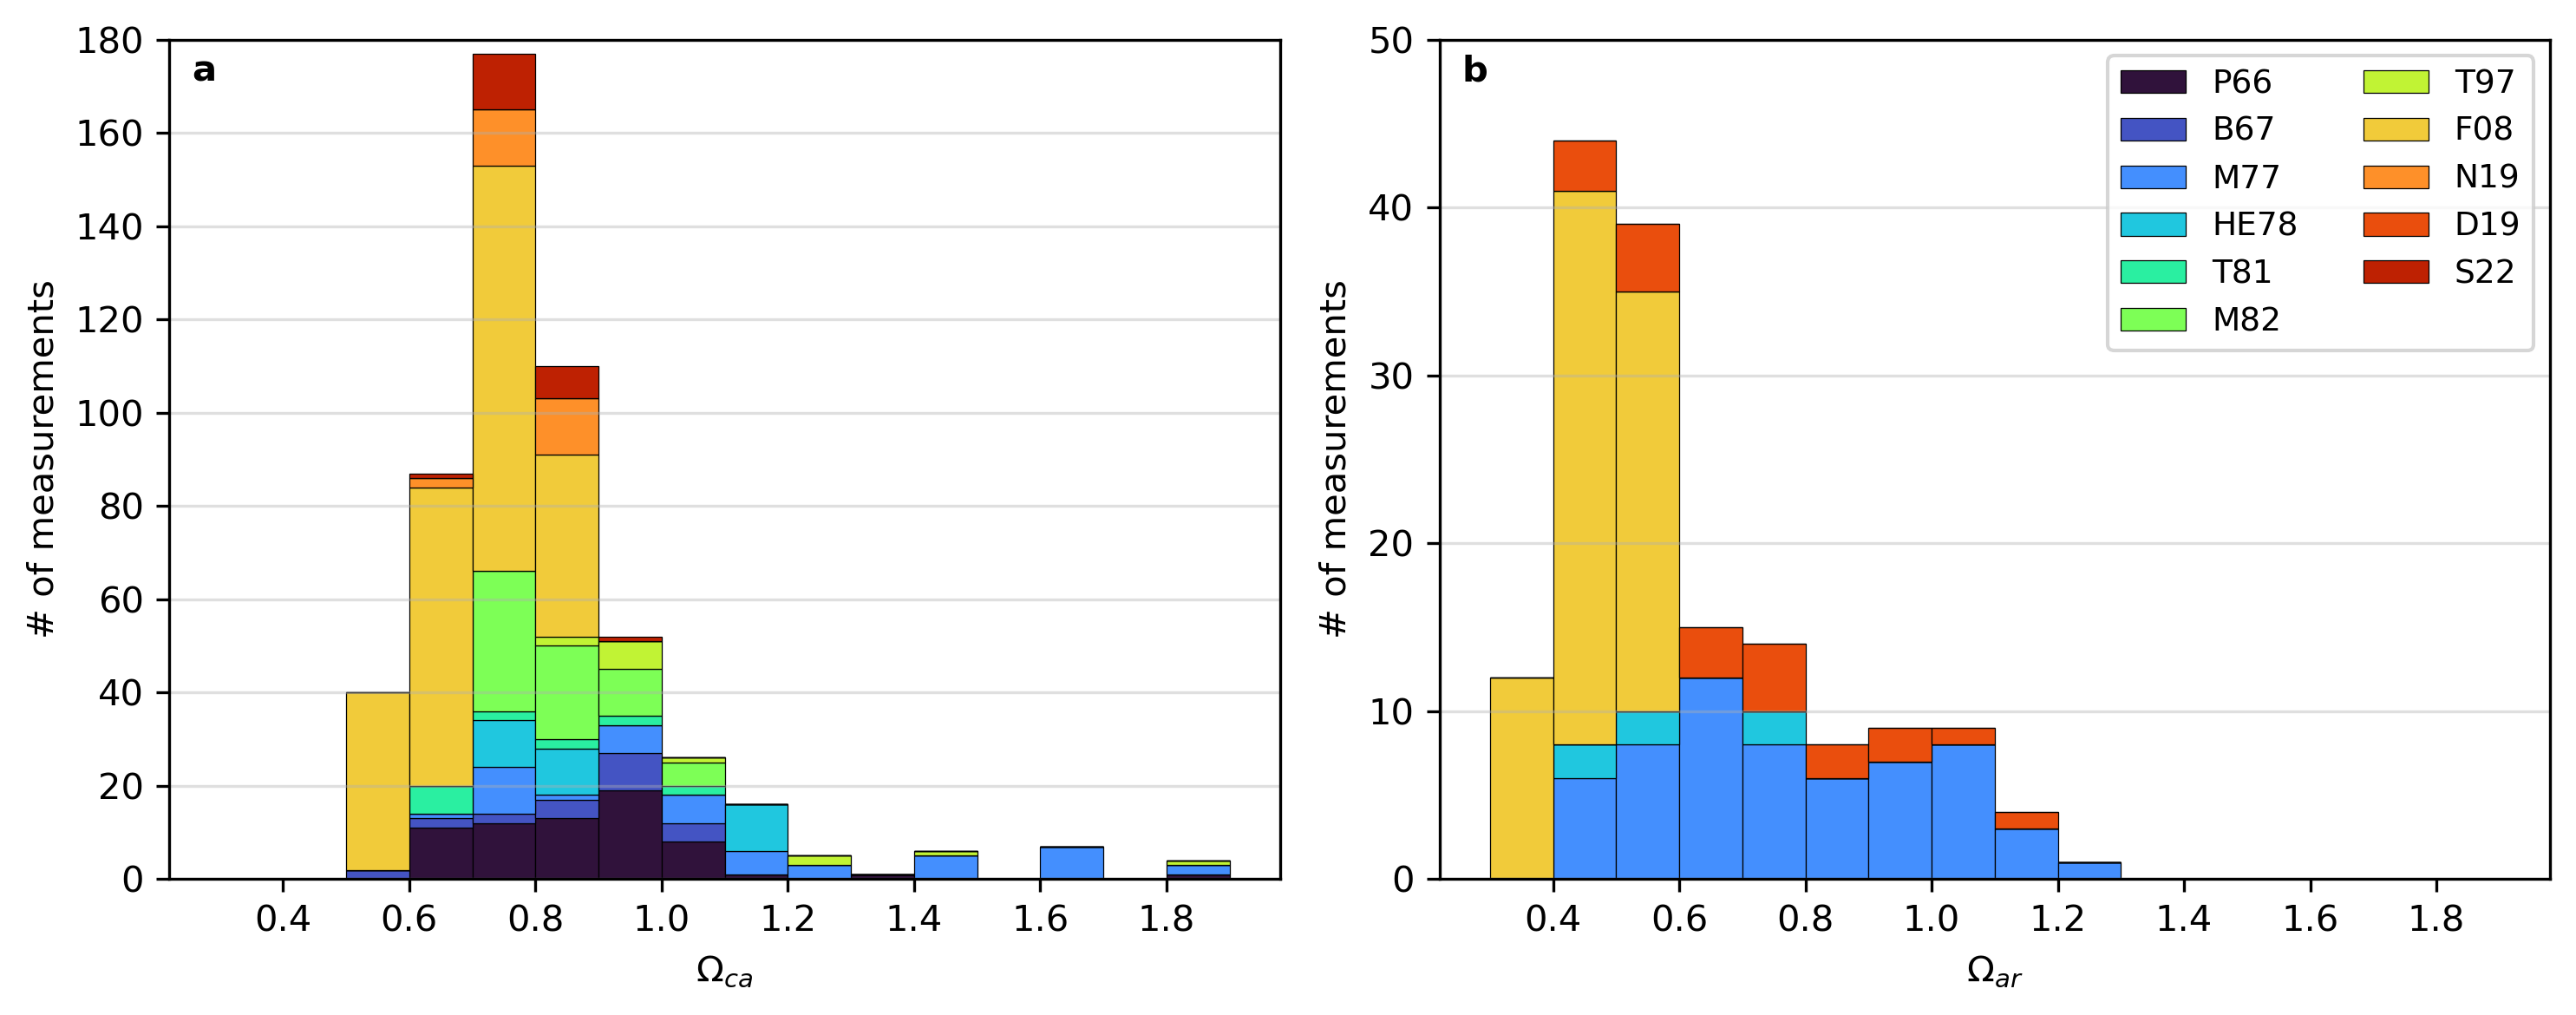

In [5]:
bins = bins = np.arange(0.3, 2, 0.1)

fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=300)

calc_hist = []
arag_hist = []

for s in df["Source_abbrev"].unique():    
    calc_hist.append(df[(df["Source_abbrev"] == s) & (df["Material"] == "Calcite")]["Omega_use"])
    arag_hist.append(df[(df["Source_abbrev"] == s) & (df["Material"] == "Aragonite")]["Omega_use"])

#c=["#dec0f9","#4cc43c","#01467f","#6d41f2","#d8790d","#db0d7e","#48d1d6","#9400c1","#d6b231","#bf4156","#c1d34c"]
axs[0].hist(calc_hist, bins=bins, stacked=True, edgecolor='black', linewidth=0.3,
         label=df["Source_abbrev"].unique(), color=colors)
axs[1].hist(arag_hist, bins=bins, stacked=True,edgecolor='black', linewidth=0.3, 
         label=df["Source_abbrev"].unique(), color=colors)

#axs[0].legend(fontsize=10, loc=2)
axs[1].legend(fontsize=9, ncol=2)
axs[0].set_ylim(0,180)
axs[1].set_ylim(0,50)
#fig.colorbar(df["Source Abbrev"].unique(), ax=axs[0])

axs[0].set_xlabel("$\Omega_{ca}$")
axs[1].set_xlabel("$\Omega_{ar}$")
axs[0].set_ylabel("# of measurements")
axs[1].set_ylabel("# of measurements")

for n,ax in enumerate(axs):
    ax.annotate(string.ascii_lowercase[n], (0.02, 0.95), xycoords='axes fraction', weight='bold')
    ax.grid(axis='y', alpha=0.4)


plt.tight_layout()
plt.show()

## Figure 5

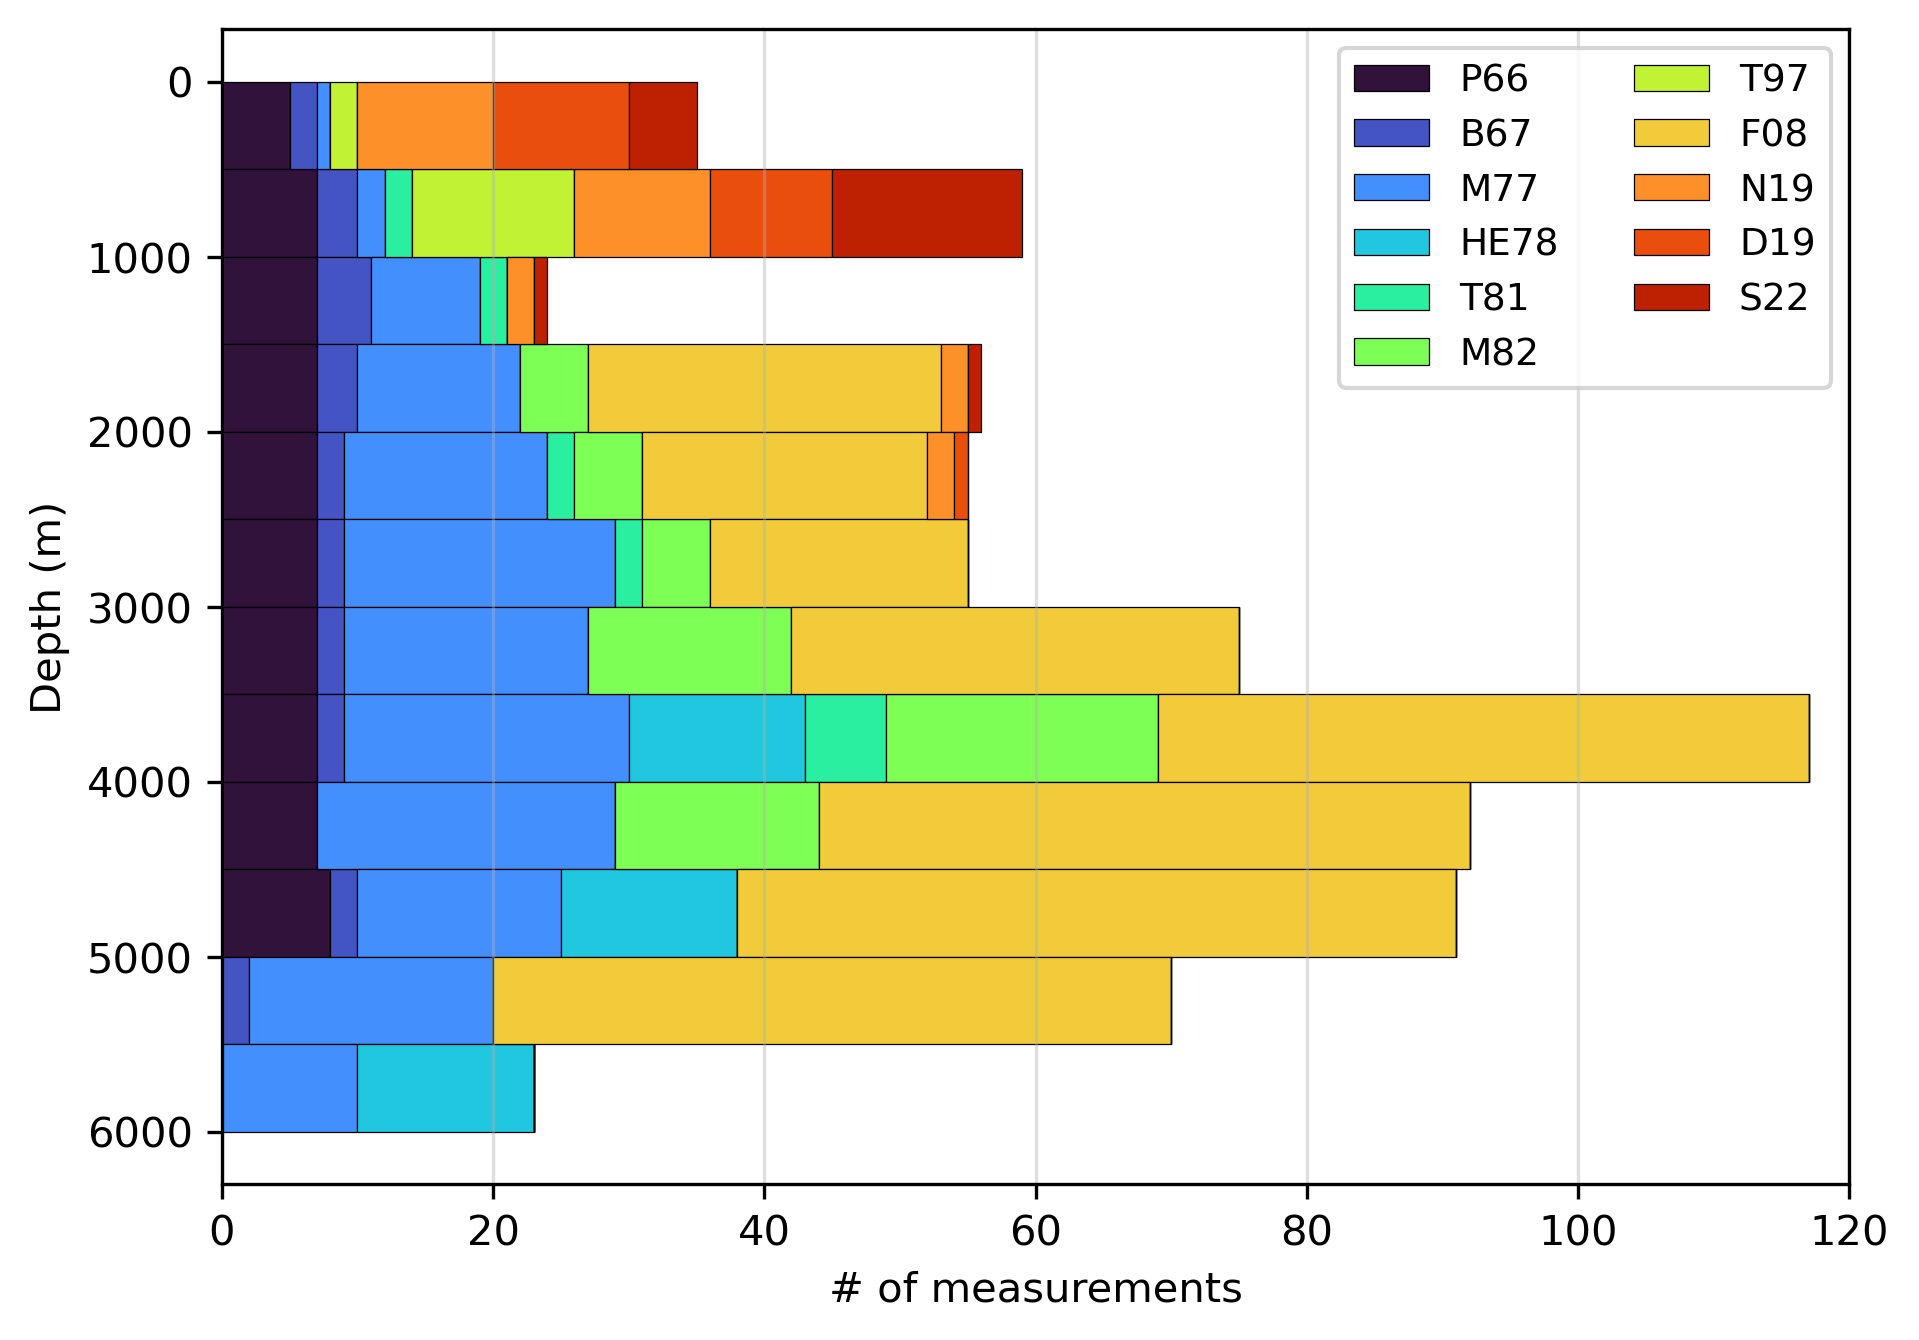

In [6]:
bins = np.arange(0,6500,500)

plt.figure(figsize=(7,5), dpi=300)

hist = []

for s in df["Source_abbrev"].unique():    
    hist.append(df[(df["Source_abbrev"] == s)]["Depth"])

#c=["#dec0f9","#4cc43c","#01467f","#6d41f2","#d8790d","#db0d7e","#48d1d6","#9400c1","#d6b231","#bf4156","#c1d34c"]
plt.hist(hist, bins=bins, stacked=True, edgecolor='black', linewidth=0.3, orientation="horizontal",
         label=df["Source_abbrev"].unique(), color=colors)
plt.gca().invert_yaxis()

plt.legend(fontsize=9, ncol=2)
plt.ylabel("Depth (m)")
plt.xlabel("# of measurements")

plt.grid(axis='x', alpha=0.4)

plt.xlim(0,120)

#plt.tight_layout()
plt.show()

# Dissolution rate as function of Ω (Figure 6)

/var/folders/38/38dzbjpx6nz16p7v6rzy9yvw0000gn/T/ipykernel_95876/2575890495.py:60: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0,3)


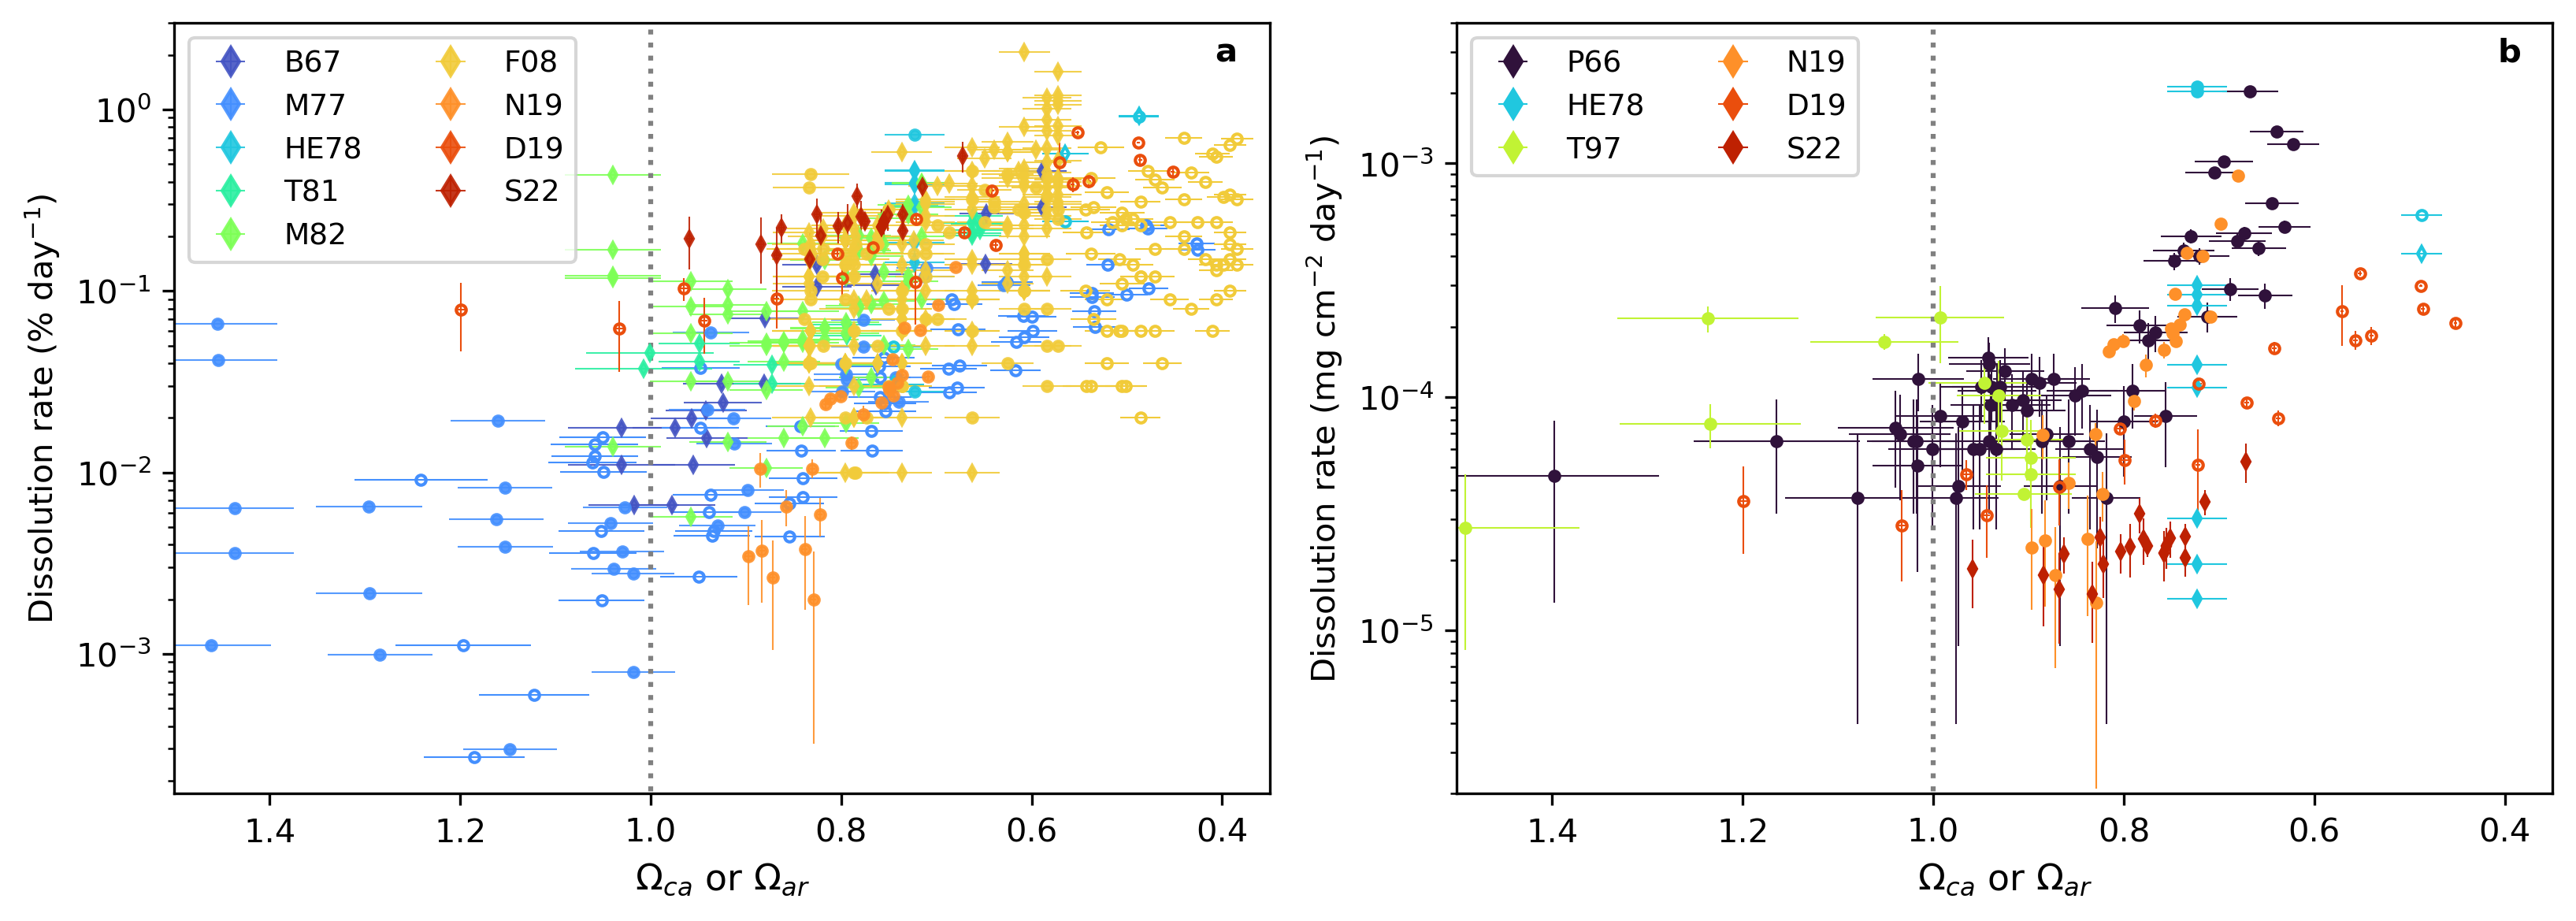

In [7]:
fig, axs = plt.subplots(1,2, figsize=(11,4), dpi=300)

#df = df.sort_values(by=["Year"], ascending=True)

for n,s in enumerate(df["Source_abbrev"].unique()):
    
        ca_bio = (df["Source_abbrev"] == s) & (df["Biogenic"] == True) & (df["Material"] == 'Calcite')
        ca_in = (df["Source_abbrev"] == s) & (df["Biogenic"] == False) & (df["Material"] == 'Calcite')
        ar_bio = (df["Source_abbrev"] == s) & (df["Biogenic"] == True) & (df["Material"] == 'Aragonite')
        ar_in = (df["Source_abbrev"] == s) & (df["Biogenic"] == False) & (df["Material"] == 'Aragonite')
        
        if s == "f08": alpha = 0.6
        else: alpha = 1
        
        if pd.isna(df[df["Source_abbrev"] == s]["Rate_mass"]).all() == False:            
            axs[0].errorbar(df[ca_bio]["Omega_use"], df[ca_bio]["Rate_mass"], 
                            xerr=df[ca_bio]['u_Omega_use'], yerr=df[ca_bio]['Rate_error_mass'],
                           fmt="d", label=s, color=colors[n], ms=3, lw=0.5, alpha=alpha-0.1)
            axs[0].errorbar(df[ca_in]["Omega_use"], df[ca_in]["Rate_mass"], 
                            xerr=df[ca_in]['u_Omega_use'], yerr=df[ca_in]['Rate_error_mass'],
                           fmt="o", color=colors[n], ms=3, lw=0.5, alpha=alpha-0.1)
            axs[0].errorbar(df[ar_bio]["Omega_use"], df[ar_bio]["Rate_mass"],
                            xerr=df[ar_bio]['u_Omega_use'], yerr=df[ar_bio]['Rate_error_mass'],
                           fmt="d", color=colors[n], ms=3, mfc='none', lw=0.5, alpha=alpha)
            axs[0].errorbar(df[ar_in]["Omega_use"], df[ar_in]["Rate_mass"], 
                            xerr=df[ar_in]['u_Omega_use'], yerr=df[ar_in]['Rate_error_mass'],
                           fmt="o", color=colors[n], ms=3, mfc='none', lw=0.5, alpha=alpha)

        if pd.isna(df[df["Source_abbrev"] == s]["Rate_sa"]).all() == False:              
            axs[1].errorbar(df[ca_bio]["Omega_use"], df[ca_bio]["Rate_sa"], 
                            xerr=df[ca_bio]['u_Omega_use'], yerr=df[ca_bio]['Rate_error_sa'],
                           fmt="d", label=s, color=colors[n], ms=3, lw=0.5)
            axs[1].errorbar(df[ca_in]["Omega_use"], df[ca_in]["Rate_sa"], 
                            xerr=df[ca_in]['u_Omega_use'], yerr=df[ca_in]['Rate_error_sa'],
                           fmt="o", color=colors[n], ms=3, lw=0.5)
            axs[1].errorbar(df[ar_bio]["Omega_use"], df[ar_bio]["Rate_sa"],
                            xerr=df[ar_bio]['u_Omega_use'], yerr=df[ar_bio]['Rate_error_sa'],
                           fmt="d", color=colors[n],ms=3, mfc='none', lw=0.5)
            axs[1].errorbar(df[ar_in]["Omega_use"], df[ar_in]["Rate_sa"], 
                            xerr=df[ar_in]['u_Omega_use'], yerr=df[ar_in]['Rate_error_sa'],
                           fmt="o", color=colors[n],ms=3, mfc='none', lw=0.5)



            
#plotline.set_markerfacecolor('none')
for a in axs:
    a.vlines(1,0,3, color="gray", linestyle="dotted")
    a.invert_xaxis()
    a.set_yscale('log')
    a.set_xlim(1.5,0.35)
    #a.set_ylim(0,3)
    a.legend(loc=2, ncol=2, markerscale=2, fontsize=9)
    #a.invert_xaxis()



axs[0].set_xlabel("$\Omega_{ca}$ or $\Omega_{ar}$", fontsize=11)
axs[0].set_ylabel("Dissolution rate (% day$^{-1}$)", fontsize=10)
axs[0].set_ylim(0,3)
    

axs[1].set_xlabel("$\Omega_{ca}$ or $\Omega_{ar}$", fontsize=11)
axs[1].set_ylabel("Dissolution rate (mg cm$^{-2}$ day$^{-1}$)", fontsize=10)
axs[1].set_ylim(2e-6,4e-3)

for n,ax in enumerate(axs):
    ax.annotate(string.ascii_lowercase[n], (0.95, 0.95), xycoords='axes fraction', weight='bold')

plt.tight_layout()
plt.show()

# Some more info

In [8]:
print('only mass-normalised')
print(df[(pd.isna(df['Rate_sa'])) & (~pd.isna(df['Rate_mass']))].shape)
print()
print('only surface-normalised')
print(df[(~pd.isna(df['Rate_sa'])) & (pd.isna(df['Rate_mass']))].shape)
print()
print('mass-normalised')
print(df[~pd.isna(df['Rate_mass'])].shape)
print()
print('surface-normalised')
print(df[~pd.isna(df['Rate_sa'])].shape)
print()
print('both provided')
print(df[(~pd.isna(df['Rate_sa'])) & (~pd.isna(df['Rate_mass']))].shape)

only mass-normalised
(588, 84)

only surface-normalised
(83, 84)

mass-normalised
(668, 84)

surface-normalised
(163, 84)

both provided
(80, 84)


In [9]:
## spread in he78 data
df_he78 = df[(df['Source_abbrev'] == 'HE78') & (df['Material'] == 'Calcite') & (df['Depth'] == 5518)]

print('mass')
print(df_he78.Rate_mass.min())
print(df_he78.Rate_mass.max())
print('surface')
print(df_he78.Rate_sa.min())
print(df_he78.Rate_sa.max())


mass
0.0278481012658227
0.7278481012658228
surface
1.3698630136986302e-05
0.0021369863013698


In [10]:
print("Calcite")
print(df[df['Material'] == "Calcite"].shape)
print(df[(df['Material'] == "Calcite") & (df['Biogenic'] == True)].shape)

print('Aragonite')
print(df[df['Material'] == "Aragonite"].shape)
print(df[(df['Material'] == "Aragonite") & (df['Biogenic'] == True)].shape)

Calcite
(537, 84)
(303, 84)
Aragonite
(156, 84)
(3, 84)


In [11]:
print("Biogenic")
print(df[df['Biogenic'] == True].shape)

Biogenic
(309, 84)
